In [1]:
"""
This notebook contains a working example show usage of the new
image similarity based saliency map API for choosing to use 
a occlusion based saliency map algorithm.

Packages required for the below example

- python 3.7 and above
- jupyter
- matplotlib
- torch
- torchvision
- PIL
- scikit-learn
- numpy
- xaitk_saliency

Note: it is not unusual for the below code to throwback a warning 
indicating missing psycopg2 and caffe modules.
Please disregard any such warnings. 

Reference for implementation: Dong B, Collins R, Hoogs A.
Explainability for Content-Based Image Retrieval.
InCVPR Workshops 2019 Jun (pp. 95-98).

License for test image used:'catdog.png' and 'dog.jpg'
Copyright (c) 2015, COCO Consortium. All rights reserved.
Redistribution and use software in source and binary form, with or
without modification, are permitted provided that the following
conditions are met:
Redistributions of source code must retain the above copyright notice,
this list of conditions and the following disclaimer. Redistributions in
binary form must reproduce the above copyright notice, this list of conditions
and the following disclaimer in the documentation and/or other materials provided
with the distribution. Neither the name of the COCO Consortium nor the
names of its contributors may be used to endorse or promote products derived
from this software without specific prior written permission. THIS SOFTWARE AND
ANNOTATIONS ARE PROVIDED BY THE COPYRIGHT HOLDERS AND CONTRIBUTORS \"AS IS\" AND
ANY EXPRESS OR IMPLIED WARRANTIES, INCLUDING, BUT NOT LIMITED TO, THE IMPLIED
WARRANTIES OF MERCHANTABILITY AND FITNESS FOR A PARTICULAR PURPOSE ARE DISCLAIMED.
IN NO EVENT SHALL THE COPYRIGHT OWNER OR CONTRIBUTORS BE LIABLE FOR ANY DIRECT,
INDIRECT, INCIDENTAL, SPECIAL, EXEMPLARY, OR CONSEQUENTIAL DAMAGES (INCLUDING
BUT NOT LIMITED TO, PROCUREMENT OF SUBSTITUTE GOODS OR SERVICES; LOSS OF USE, DATA,
OR PROFITS; OR BUSINESS INTERRUPTION) HOWEVER CAUSED AND ON ANY THEORY OF LIABILITY
WHETHER IN CONTRACT, STRICT LIABILITY, OR TORT (INCLUDING NEGLIGENCE OR OTHERWISE)
ARISING IN ANY WAY OUT OF THE USE OF THIS SOFTWARE, EVEN IF ADVISED OF THE POSSIBILITY
OF SUCH DAMAGE.
"""
from xaitk_saliency.impls.perturb_image.sliding_window import SlidingWindowPerturb
from xaitk_saliency.impls.vis_sal_similarity.similarityscoring import SimilarityScoring

import matplotlib.pyplot as plt
from PIL import Image
from torchvision import transforms
from torch.autograd import Variable
import torchvision.models as models
import torch
import numpy as np


# Test image to be explained
test_image1_path = 'catdog.png'
test_image2_path = 'dog.jpg'

# Constructing xaitk implementations for SimilarityBased Saliency genration with
# sliding windows.
slid_algo = SlidingWindowPerturb(window_size=(24, 24), stride=(5, 5))
occ_alg = SimilarityScoring()

# Creating an example deep feature extractor to describe images
model = models.resnet18(pretrained=True)
model = model.eval()
model = model.cuda()

In [2]:
# Input image loader to match feature extractor expectation
imsize = 224
loader = transforms.Compose([transforms.Resize((imsize)), transforms.ToTensor()])

def image_loader(image_name):
    try:
        image = Image.open(image_name)
    except AttributeError:
        # If Image already open
        image = image_name
    image = loader(image).float()
    image = Variable(image, requires_grad=False)
    return image.cuda().unsqueeze(0)

def predict_with_model(model, image_tensor):
    featureVec = model(image_tensor)
    return featureVec.cpu().detach().numpy().squeeze()

def compute_prtb_feats(p_image):
    # Use created sliding window based perturbation algorithm to perturb test image
    pert_img, pertmask = slid_algo.perturb(p_image)
    # Compute feature vectors on perturbed version of the test image
    prtbd_feat = np.array([predict_with_model(model, image_loader(ptrbed)) for ptrbed in pert_img])
    return pert_img, pertmask, prtbd_feat

# Test images containing cat and dog.
test_image1 = Image.open(test_image1_path).resize((imsize, imsize))
test_image2 = Image.open(test_image2_path).resize((imsize, imsize))

# Compute original feature vector on test images
org_feat_1 = predict_with_model(model, image_loader(test_image1))
org_feat_2 = predict_with_model(model, image_loader(test_image2))

# Perturb both test images
pert_img1, pertmask1, prtbd_feat1 = compute_prtb_feats(test_image1)
pert_img2, pertmask2, prtbd_feat2 = compute_prtb_feats(test_image2)

In [3]:
# Generating final saliency map for all permutations of two test images
img1_img1_sal = occ_alg.generate(org_feat_1, org_feat_1, prtbd_feat1, pertmask1)
img1_img2_sal = occ_alg.generate(org_feat_1, org_feat_2, prtbd_feat2, pertmask2)
img2_img1_sal = occ_alg.generate(org_feat_2, org_feat_1, prtbd_feat1, pertmask1)
img2_img2_sal = occ_alg.generate(org_feat_2, org_feat_2, prtbd_feat2, pertmask2)

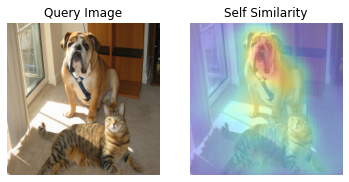

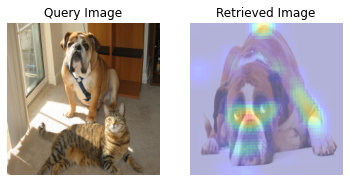

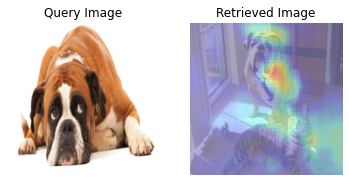

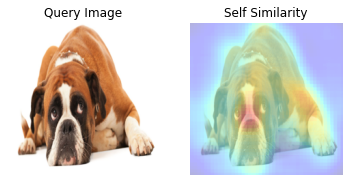

In [6]:
plt.figure()
local_var = locals()

for plt_i, (q_n, r_n) in enumerate(zip([1, 1, 2, 2], [1, 2, 1, 2])):
    plt.subplot(1, 2, 1)
    plt.imshow(local_var['test_image{}'.format(q_n)])
    plt.axis('off')
    plt.title('Query Image')

    plt.subplot(1, 2, 2)
    plt.imshow(local_var['test_image{}'.format(r_n)], alpha=0.5)               
    plt.imshow((local_var['img{}_img{}_sal'.format(q_n, r_n)])[0], cmap='jet', alpha=0.3)
    plt.axis('off')
    if q_n == r_n:
        plt.title('Self Similarity')
    else:
        plt.title('Retrieved Image')
    plt.show()